In [1]:
#importação das bibliotecas necessárias 
#variaveis globais 
#configuração da gpu

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os 

img_size = (224,224)
seed = 42
batch_size = 32
epochs = 80 

print(tf.config.list_physical_devices('GPU'))

2025-10-23 17:14:35.376772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 17:14:35.789430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 17:14:38.195055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#Carregamento base de dados 

train_ds = tf.keras.utils.image_dataset_from_directory(
    "data/dataset_eye_disease/train/",
    validation_split=0.2,      
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data/dataset_eye_disease/train/",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/dataset_eye_disease/test/",
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Classes encontradas: {class_names}")
print(f"Número de classes: {num_classes}")

Found 3796 files belonging to 4 classes.
Using 3037 files for training.


I0000 00:00:1761250481.863804    6294 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3796 files belonging to 4 classes.
Using 759 files for validation.
Found 429 files belonging to 4 classes.
Classes encontradas: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Número de classes: 4


In [3]:
#otimiza carregamento de dados
AUTOTUNE = tf.data.AUTOTUNE

#pipeline do data augmentation e as transformações
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.07),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.07, 0.07),
        tf.keras.layers.RandomBrightness(0.15),
        tf.keras.layers.RandomContrast(0.1)
    ],
    name="data_augmentation_clinical"
)

#pré processamento dos dados de treino
train_ds = (
    train_ds
    .map(lambda x, y: (data_augmentation(x, training=True), y),
         num_parallel_calls=AUTOTUNE)
    .shuffle(1000, seed=seed)
    .cache()
    .prefetch(AUTOTUNE)
)

#pré processamento dos dados de validação 
val_ds = (
    val_ds
    .cache()
    .prefetch(AUTOTUNE)
)

#pré processamento dos dados de teste
test_ds = (
    test_ds
    .cache()
    .prefetch(AUTOTUNE)
)

In [4]:
#toda a arquitetura do modelo

from tensorflow.keras import layers, regularizers, models

model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Rescaling(1./255),

        #primeiro bloco convolucional
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.15),

        #segundo bloco convolucional
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.20),

        #terceiro bloco convolucional
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.25),

        #quarto bloco convolucional
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.30),

        #camada densa
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')
])

model.summary()

/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 64)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,531,524 (9.66 MB)

 Trainable params: 2,527,428 (9.64 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [5]:
#definição do otimizador e compilação do modelo
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

#define um agendador de taxa de aprendizado cíclico
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=3e-4, #taxa de aprendizado inicial
    first_decay_steps=15,  #duração do primeiro ciclo em épocas
    t_mul=1.5,   #multiplica o tamanho de cada ciclo subsequente
    m_mul=0.9,   #reduz a amplitude máxima do LR a cada reinício
    alpha=1e-6   #taxa mínima 
)
#define o otimizador AdamW
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

#Compilação do modelo com as métricas e loss
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  
)

In [6]:
#definição dos callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#early stoppin para parar o treinamento se o modelo não aprender
early_stopping = EarlyStopping(
    monitor='val_loss',       #métrica a ser avaliada     
    patience=40,              #quantas épocas até parar o treinamento 
    restore_best_weights=True, #restaura os melhores pesos
    verbose = 1 #manda msg que parou
)

#callback para salvar o melhor modelo
checkpoint = ModelCheckpoint(
    filepath='best_model.keras', #o nome do arquivo que vai salvar
    monitor='val_loss', #métrica que vai ser avaliada
    save_best_only=True,  #salvar apenas o melhor
    verbose=1 #manda msg que salvou
)


callbacks_list = [early_stopping,  checkpoint]


In [7]:
#treinamento do modelo
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks_list
)

Epoch 1/80


2025-10-22 17:24:12.870443: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ec128036ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-22 17:24:12.870459: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-22 17:24:13.041296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-22 17:24:14.014453: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-22 17:24:14.428970: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-22 17:24

52/95 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.2890 - loss: 2.0259

2025-10-22 17:25:27.767884: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 17:25:45.024696: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[29,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-10-22 17:25:45.336187: E external/local_xla/xla/service/slow_operation_alarm.c

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.3087 - loss: 1.9608

2025-10-22 17:26:29.117777: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from None to 1.40673, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.3388 - loss: 1.8635 - val_accuracy: 0.2227 - val_loss: 1.4067
Epoch 2/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.3901 - loss: 1.6473
Epoch 2: val_loss did not improve from 1.40673
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 522ms/step - accuracy: 0.3793 - loss: 1.6672 - val_accuracy: 0.2767 - val_loss: 1.4319
Epoch 3/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4000 - loss: 1.5888
Epoch 3: val_loss did not improve from 1.40673
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 521ms/step - accuracy: 0.4083 - loss: 1.5640 - val_accuracy: 0.2978 - val_loss: 1.5623
Epoch 4/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4258 - loss: 1.4936
Epoch 4: val_loss did not improve from 1.40673
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 522ms/step - accuracy: 0.4231 - loss: 1.5020 - val_accuracy: 0.2938 - val_loss: 1.7572
Epoch 5/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/s

In [8]:
#mostra das métricas no conjunto de dados de validação
val_loss, val_acc = model.evaluate(val_ds)
print(f"Acurácia de Validação: {val_acc:.4f}")
print(f"Perda de Validação: {val_loss:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8024 - loss: 0.5519
Acurácia de Validação: 0.8024
Perda de Validação: 0.5519


In [6]:
#Importação e carregamento do modelo treinado 
from tensorflow.keras.models import load_model
import numpy as np
from pathlib import Path

#carregamento do melhor modelo 
model_path = Path("best_model.keras")
model = load_model(model_path)

#listas de valores verdadeiros e preditos
y_true = []
y_pred = []

#geração das previsões sobre o conjunto de validação
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

#conversão para numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2025-10-23 17:16:57.941671: I external/local_xla/xla/service/service.cc:163] XLA service 0x778558011a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-23 17:16:57.941698: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-23 17:16:57.980948: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-23 17:16:58.178823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-23 17:17:01.710309: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:176125063

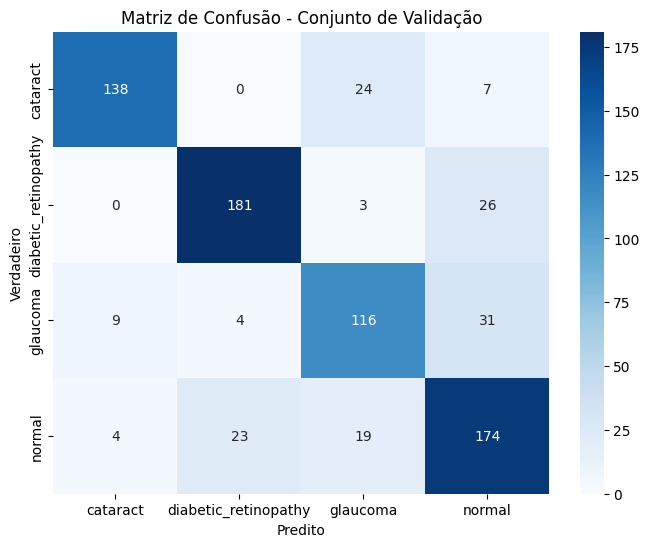

In [8]:
#print matriz 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Conjunto de Validação")
plt.savefig("confusion_matrix.png")
plt.show()


In [11]:
#print das métricas por classe
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Relatório de Classificação:\n")
print(report)

Relatório de Classificação:

                      precision    recall  f1-score   support

            cataract     0.9139    0.8166    0.8625       169
diabetic_retinopathy     0.8702    0.8619    0.8660       210
            glaucoma     0.7160    0.7250    0.7205       160
              normal     0.7311    0.7909    0.7598       220

            accuracy                         0.8024       759
           macro avg     0.8078    0.7986    0.8022       759
        weighted avg     0.8071    0.8024    0.8038       759

